In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 2048000)           8192000   
_________________________________________________________________
dense (Dense)                (None, 16)                32768016  
Total params: 40,961,296
Trainable params: 36,865,040
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7750 - acc: 0.4847
Epoch 00001: val_loss improved from inf to 1.55743, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_4_conv_checkpoint/001-1.5574.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 1.7750 - acc: 0.4847 - val_loss: 1.5574 - val_acc: 0.5183
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1033 - acc: 0.6813
Epoch 00002: val_loss improved from 1.55743 to 1.25767, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_4_conv_checkpoint/002-1.2577.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 1.1032 - acc: 0.6813 - val_loss: 1.2577 - val_acc: 0.6459
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7793 - acc: 0.7682
Epoch 00003: val_loss did not improve from 1.25767
36805/36805 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9950
Epoch 00028: val_loss did not improve from 1.13707
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.0299 - acc: 0.9950 - val_loss: 1.6397 - val_acc: 0.6962
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9951
Epoch 00029: val_loss did not improve from 1.13707
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.0302 - acc: 0.9950 - val_loss: 1.7146 - val_acc: 0.6834
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0493 - acc: 0.9887
Epoch 00030: val_loss did not improve from 1.13707
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.0493 - acc: 0.9886 - val_loss: 1.6646 - val_acc: 0.6853
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9937
Epoch 00031: val_loss did not improve from 1.13707
36805/36805 [========

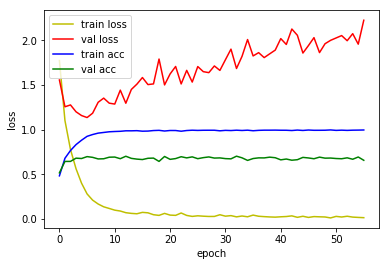

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.2746 - acc: 0.6557
Loss: 1.274618286234815 Accuracy: 0.6556594

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6682 - acc: 0.4936
Epoch 00001: val_loss improved from inf to 1.46961, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_5_conv_checkpoint/001-1.4696.hdf5
36805/36805 [==============================] - 183s 5ms/sample - loss: 1.6683 - acc: 0.4936 - val_loss: 1.4696 - val_acc: 0.5379
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0773 - acc: 0.6776
Epoch 00002: val_loss improved from 1.46961 to 1.08583, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_5_conv_checkpoint/002-1.0858.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 1.0775 - acc: 0.6775 - val_loss: 1.0858 - val_acc: 0.6962
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0729 - acc: 0.9851
Epoch 00027: val_loss did not improve from 0.80905
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0732 - acc: 0.9850 - val_loss: 1.0534 - val_acc: 0.7563
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0737 - acc: 0.9844
Epoch 00028: val_loss did not improve from 0.80905
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0740 - acc: 0.9843 - val_loss: 0.9484 - val_acc: 0.7815
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9882
Epoch 00029: val_loss did not improve from 0.80905
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0613 - acc: 0.9882 - val_loss: 1.0993 - val_acc: 0.7480
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0585 - acc: 0.9884
Epoch 00030: val_loss did not improve from 0.80905
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9929
Epoch 00057: val_loss did not improve from 0.80905
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0356 - acc: 0.9928 - val_loss: 1.1012 - val_acc: 0.7862
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.80905
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0274 - acc: 0.9951 - val_loss: 1.1639 - val_acc: 0.7759
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9980
Epoch 00059: val_loss did not improve from 0.80905
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0180 - acc: 0.9980 - val_loss: 1.1552 - val_acc: 0.7761
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9926
Epoch 00060: val_loss did not improve from 0.80905
36805/36805 [========

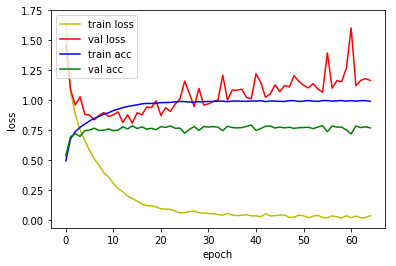

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.9102 - acc: 0.7497
Loss: 0.9101950282991118 Accuracy: 0.7497404

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8158 - acc: 0.4407
Epoch 00001: val_loss improved from inf to 1.47512, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_6_conv_checkpoint/001-1.4751.hdf5
36805/36805 [==============================] - 187s 5ms/sample - loss: 1.8157 - acc: 0.4408 - val_loss: 1.4751 - val_acc: 0.5334
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1394 - acc: 0.6574
Epoch 00002: val_loss improved from 1.47512 to 1.12510, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_6_conv_checkpoint/002-1.1251.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 1.1394 - acc: 0.6574 - val_loss: 1.1251 - val_acc: 0.6490
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1307 - acc: 0.9668
Epoch 00027: val_loss did not improve from 0.49009
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1309 - acc: 0.9667 - val_loss: 0.6021 - val_acc: 0.8416
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1269 - acc: 0.9682
Epoch 00028: val_loss did not improve from 0.49009
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1269 - acc: 0.9682 - val_loss: 0.4935 - val_acc: 0.8710
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1113 - acc: 0.9730
Epoch 00029: val_loss did not improve from 0.49009
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1115 - acc: 0.9730 - val_loss: 0.5201 - val_acc: 0.8651
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1092 - acc: 0.9737
Epoch 00030: val_loss did not improve from 0.49009
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9915
Epoch 00057: val_loss did not improve from 0.49009
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0432 - acc: 0.9915 - val_loss: 0.5382 - val_acc: 0.8849
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9953
Epoch 00058: val_loss did not improve from 0.49009
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0312 - acc: 0.9952 - val_loss: 0.6345 - val_acc: 0.8595
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9882
Epoch 00059: val_loss did not improve from 0.49009
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0519 - acc: 0.9882 - val_loss: 0.5474 - val_acc: 0.8807
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9933
Epoch 00060: val_loss did not improve from 0.49009
36805/36805 [========

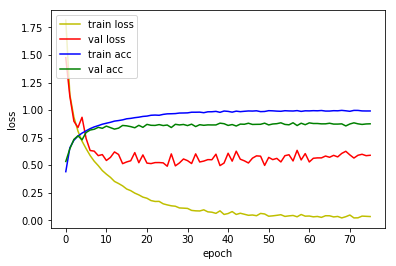

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.5948 - acc: 0.8355
Loss: 0.5948092682958268 Accuracy: 0.835514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1630 - acc: 0.3370
Epoch 00001: val_loss improved from inf to 1.80855, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_7_conv_checkpoint/001-1.8086.hdf5
36805/36805 [==============================] - 192s 5ms/sample - loss: 2.1629 - acc: 0.3371 - val_loss: 1.8086 - val_acc: 0.4405
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3498 - acc: 0.5889
Epoch 00002: val_loss improved from 1.80855 to 1.16543, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_7_conv_checkpoint/002-1.1654.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 1.3502 - acc: 0.5889 - val_loss: 1.1654 - val_acc: 0.6506
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1974 - acc: 0.9452
Epoch 00024: val_loss improved from 0.33539 to 0.31129, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_7_conv_checkpoint/024-0.3113.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1975 - acc: 0.9452 - val_loss: 0.3113 - val_acc: 0.9115
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1901 - acc: 0.9473
Epoch 00025: val_loss did not improve from 0.31129
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1900 - acc: 0.9473 - val_loss: 0.3422 - val_acc: 0.9045
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1722 - acc: 0.9519
Epoch 00026: val_loss did not improve from 0.31129
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1723 - acc: 0.9518 - val_loss: 0.3350 - val_acc: 0.9043
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0602 - acc: 0.9859
Epoch 00052: val_loss did not improve from 0.29281
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0605 - acc: 0.9859 - val_loss: 0.3197 - val_acc: 0.9147
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0569 - acc: 0.9865
Epoch 00053: val_loss did not improve from 0.29281
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0572 - acc: 0.9865 - val_loss: 0.3474 - val_acc: 0.9092
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.9836
Epoch 00054: val_loss did not improve from 0.29281
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0626 - acc: 0.9835 - val_loss: 0.2947 - val_acc: 0.9248
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9909
Epoch 00055: val_loss did not improve from 0.29281
36805/36805 [========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9947
Epoch 00082: val_loss did not improve from 0.29281
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0266 - acc: 0.9946 - val_loss: 0.3890 - val_acc: 0.9096
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9890
Epoch 00083: val_loss did not improve from 0.29281
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0425 - acc: 0.9890 - val_loss: 0.3335 - val_acc: 0.9220
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9957
Epoch 00084: val_loss did not improve from 0.29281
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0219 - acc: 0.9957 - val_loss: 0.3303 - val_acc: 0.9215
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9956
Epoch 00085: val_loss did not improve from 0.29281
36805/36805 [========

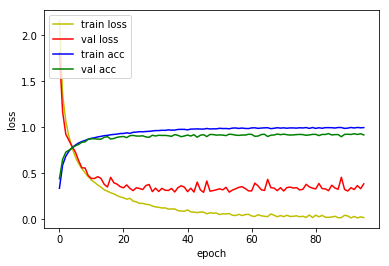

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.3492 - acc: 0.9007
Loss: 0.3491537195747391 Accuracy: 0.9007269

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2038 - acc: 0.3223
Epoch 00001: val_loss improved from inf to 1.89031, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_8_conv_checkpoint/001-1.8903.hdf5
36805/36805 [==============================] - 197s 5ms/sample - loss: 2.2037 - acc: 0.3223 - val_loss: 1.8903 - val_acc: 0.4172
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3443 - acc: 0.5985
Epoch 00002: val_loss improved from 1.89031 to 1.12660, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_8_conv_checkpoint/002-1.1266.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 1.3443 - acc: 0.5985 - val_loss: 1.1266 - val_acc: 0.6608
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9643
Epoch 00024: val_loss did not improve from 0.21520
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1332 - acc: 0.9643 - val_loss: 0.2203 - val_acc: 0.9345
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9657
Epoch 00025: val_loss did not improve from 0.21520
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1283 - acc: 0.9656 - val_loss: 0.2450 - val_acc: 0.9324
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1390 - acc: 0.9605
Epoch 00026: val_loss did not improve from 0.21520
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1390 - acc: 0.9605 - val_loss: 0.2233 - val_acc: 0.9387
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1109 - acc: 0.9700
Epoch 00027: val_loss did not improve from 0.21520
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9952
Epoch 00053: val_loss did not improve from 0.20910
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0261 - acc: 0.9952 - val_loss: 0.2322 - val_acc: 0.9429
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9946
Epoch 00054: val_loss did not improve from 0.20910
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0263 - acc: 0.9946 - val_loss: 0.2408 - val_acc: 0.9383
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9933
Epoch 00055: val_loss did not improve from 0.20910
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0305 - acc: 0.9933 - val_loss: 0.2256 - val_acc: 0.9446
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9952
Epoch 00056: val_loss did not improve from 0.20910
36805/36805 [=====================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9970
Epoch 00083: val_loss did not improve from 0.20910
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0137 - acc: 0.9970 - val_loss: 0.2650 - val_acc: 0.9385
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9904
Epoch 00084: val_loss did not improve from 0.20910
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0330 - acc: 0.9904 - val_loss: 0.2543 - val_acc: 0.9392
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9929
Epoch 00085: val_loss did not improve from 0.20910
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0261 - acc: 0.9929 - val_loss: 0.2400 - val_acc: 0.9471
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9984
Epoch 00086: val_loss did not improve from 0.20910
36805/36805 [========

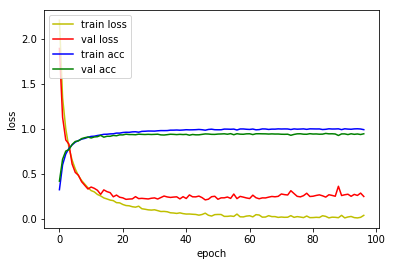

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2729 - acc: 0.9240
Loss: 0.27291673340158673 Accuracy: 0.92398757

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1069 - acc: 0.3512
Epoch 00001: val_loss improved from inf to 1.70987, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_9_conv_checkpoint/001-1.7099.hdf5
36805/36805 [==============================] - 205s 6ms/sample - loss: 2.1069 - acc: 0.3512 - val_loss: 1.7099 - val_acc: 0.5171
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1623 - acc: 0.6621
Epoch 00002: val_loss improved from 1.70987 to 1.03963, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_9_conv_checkpoint/002-1.0396.hdf5
36805/36805 [==============================] - 183s 5ms/sample - loss: 1.1625 - acc: 0.6620 - val_loss: 1.0396 - val_acc: 0.7016
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.1165 - acc: 0.9672
Epoch 00024: val_loss did not improve from 0.20854
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.1166 - acc: 0.9672 - val_loss: 0.2293 - val_acc: 0.9329
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1077 - acc: 0.9705
Epoch 00025: val_loss did not improve from 0.20854
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1079 - acc: 0.9704 - val_loss: 0.2201 - val_acc: 0.9371
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1001 - acc: 0.9724
Epoch 00026: val_loss improved from 0.20854 to 0.20058, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_BN_9_conv_checkpoint/026-0.2006.hdf5
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.1001 - acc: 0.9724 - val_loss: 0.2006 - val_acc: 0.9411
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0927 -

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9920
Epoch 00053: val_loss did not improve from 0.19614
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0321 - acc: 0.9920 - val_loss: 0.2385 - val_acc: 0.9364
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9954
Epoch 00054: val_loss did not improve from 0.19614
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0232 - acc: 0.9954 - val_loss: 0.2236 - val_acc: 0.9401
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9945
Epoch 00055: val_loss did not improve from 0.19614
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0252 - acc: 0.9945 - val_loss: 0.2426 - val_acc: 0.9336
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9901
Epoch 00056: val_loss did not improve from 0.19614
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9950
Epoch 00083: val_loss did not improve from 0.19614
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0193 - acc: 0.9950 - val_loss: 0.2372 - val_acc: 0.9429
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9974
Epoch 00084: val_loss did not improve from 0.19614
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0136 - acc: 0.9974 - val_loss: 0.2248 - val_acc: 0.9490
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9955
Epoch 00085: val_loss did not improve from 0.19614
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0176 - acc: 0.9955 - val_loss: 0.2426 - val_acc: 0.9441
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9986
Epoch 00086: val_loss did not improve from 0.19614
36805/36805 [========

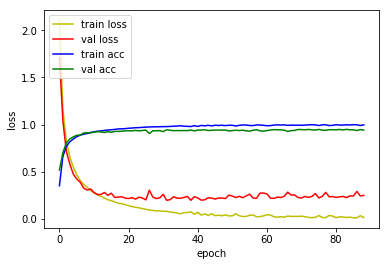

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2554 - acc: 0.9259
Loss: 0.25539070464678393 Accuracy: 0.9258567



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_ch_128_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_128_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.5948 - acc: 0.8355
Loss: 0.5948092682958268 Accuracy: 0.835514

1D_CNN_custom_4_ch_128_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_61 (Activation)   (None, 

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2729 - acc: 0.9240
Loss: 0.27291673340158673 Accuracy: 0.92398757

1D_CNN_custom_4_ch_128_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_76 (Activation)   (Non

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_128_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.7439 - acc: 0.8449
Loss: 0.7438777809821433 Accuracy: 0.84485984

1D_CNN_custom_4_ch_128_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_61 (Activation)   (Non

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3248 - acc: 0.9271
Loss: 0.32484145322940305 Accuracy: 0.9271028

1D_CNN_custom_4_ch_128_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_76 (Activation)   (Non